In [1]:
from __future__ import print_function
import os
import sys
import glob
import time
import fnmatch
import argparse
import numpy as np
from PIL import Image
from tensorflow import keras
import conf
import random
import augment
import models
import json
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.utils import plot_model

In [7]:
from train import *
from __future__ import print_function
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input
from tensorflow.keras.layers import Dense, Lambda, ELU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.optimizers import Adadelta

# Add this to get plot_model working
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [107]:
'''
Donkey_gym and all associated packages are created by: Tawn Kramer
'''

model_name='models\20190329_run_15_PID'
inputs='./log/*.jpg'

'''
modify config.json to select the model to train.
'''
model = models.get_nvidia_model(conf.num_outputs)

'''
display layer summary and weights info
'''
#Show current model summary
models.show_model_summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 120, 160, 3)       0         
_________________________________________________________________
cropping2d_16 (Cropping2D)   (None, 110, 160, 3)       0         
_________________________________________________________________
lambda_16 (Lambda)           (None, 110, 160, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 78, 24)        1824      
_________________________________________________________________
dropout_98 (Dropout)         (None, 53, 78, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 37, 32)        19232     
_________________________________________________________________
dropout_99 (Dropout)         (None, 25, 37, 32)        0         
__________

In [102]:

callbacks = [
# set the model to stop early if results are not improving automatically
        keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=conf.training_patience, 
                                      verbose=0),
# set what to save from the model as it moves through the evaluation
        keras.callbacks.ModelCheckpoint(model_name, 
                                        monitor='val_loss', 
                                        save_best_only=True, verbose=0),]

In [103]:
# Train on session images,
#  make_generators comes from Train.py, return train and validation values.
train_generator, validation_generator, n_train, n_val = make_generators(inputs, 
                                                                        limit=None, 
                                                                        batch_size=batch_size, 
                                                                        aug_perc=0.0)

if n_train == 0:
    print('no training data found')

found 10014 files
num train/val 8005 2009


In [104]:
# Creates batch size and steps for epochs and validation
batch_size = conf.training_batch_size  # =128
steps_per_epoch = n_train // batch_size
validation_steps = n_val // batch_size

print("steps_per_epoch", steps_per_epoch, "validation_steps", validation_steps)

steps_per_epoch 62 validation_steps 15


In [94]:
# %load models.py
# modifies layout of the model

def show_model_summary(model):
    model.summary()
    for layer in model.layers:
        print(layer.output_shape)

def get_nvidia_model(num_outputs):
    '''
    this model is inspired by the NVIDIA paper
    https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
    Activation is ELU
    '''
    row, col, ch = conf.row, conf.col, conf.ch
    
    drop = 0.2
    
    img_in = Input(shape=(row, col, ch), name='img_in')
    x = img_in
    x = Cropping2D(cropping=((10,0), (0,0)))(x) #trim 10 pixels off top
    x = Lambda(lambda x: x/127.5 - 1.)(x) # normalize and re-center
    # Convolution Layer with 24 filters and a kernel size of 5
    x = Conv2D(24, (5,5), strides=(2,2), activation='relu', name="conv2d_1")(x)
    # Dropout layer, drops 20% of neurons for next layer
    x = Dropout(drop)(x)
    # Convolution Layer with 32 filters and kernel size of 5
    x = Conv2D(32, (5,5), strides=(2,2), activation='relu', name="conv2d_2")(x)
    # Dropout layer, drops 20% of neurons for next layer
    x = Dropout(drop)(x)
    # Convolution Layer with 64 filters and kernel size of 5
    x = Conv2D(64, (5,5), strides=(2,2), activation='relu', name="conv2d_3")(x) 
    # Dropout layer, drops 20% of neurons for next layer
    x = Dropout(drop)(x)
    # Convolution Layer with 64 filters and kernel size of3
    x = Conv2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_4")(x)
    # Max Pooling (down-sampling) with strides of 2
    x = MaxPool2D(pool_size=2, strides=2, name='pool_1')(x) #Dropout(drop)(x)
    # Convolution Layer with 64 filters and kernel size of 3
    x = Conv2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_5")(x)
    # Dropout layer, drops 20% of neurons for next layer
    x = Dropout(drop)(x)
    
    x = Flatten(name='flattened')(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(drop)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(drop)(x)

    outputs = []
    outputs.append(Dense(num_outputs, activation='linear', name='steering_throttle')(x))
    
        
    model = Model(inputs=[img_in], outputs=outputs) 
    model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])
    return model


In [105]:
# conf.num_outputs=2 for Steering and Throttle training
model = get_nvidia_model(conf.num_outputs)

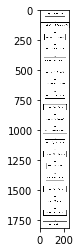

<Figure size 7200x8640 with 0 Axes>

<Figure size 7200x8640 with 0 Axes>

In [109]:
# create models as png file
plot_model(model, to_file=model_name+'.png')
data = plt.imread(model_name+'.png')
plt.imshow(data)
plt.show()
plt.figure(figsize=(100,120))

In [97]:
# Select Number of Epochs to train over
epochs = 50
models.show_model_summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 120, 160, 3)       0         
_________________________________________________________________
cropping2d_13 (Cropping2D)   (None, 110, 160, 3)       0         
_________________________________________________________________
lambda_13 (Lambda)           (None, 110, 160, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 78, 24)        1824      
_________________________________________________________________
dropout_78 (Dropout)         (None, 53, 78, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 37, 32)        19232     
_________________________________________________________________
dropout_79 (Dropout)         (None, 25, 37, 32)        0         
__________

In [98]:
%%time
# run model
history = model.fit_generator(train_generator, 
    steps_per_epoch = steps_per_epoch,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks)

Epoch 1/50
62/62 [==============================] - 446s 7s/step - loss: 1.1681 - acc: 0.6083 - val_loss: 1.0204 - val_acc: 0.6044
Epoch 2/50
62/62 [==============================] - 433s 7s/step - loss: 1.0343 - acc: 0.6037 - val_loss: 1.0103 - val_acc: 0.6081
Epoch 3/50
62/62 [==============================] - 427s 7s/step - loss: 1.0126 - acc: 0.6113 - val_loss: 1.0532 - val_acc: 0.6155
Epoch 4/50
62/62 [==============================] - 424s 7s/step - loss: 1.0040 - acc: 0.6066 - val_loss: 0.9978 - val_acc: 0.6076
Epoch 5/50
62/62 [==============================] - 426s 7s/step - loss: 0.9974 - acc: 0.6108 - val_loss: 0.9783 - val_acc: 0.6161
Epoch 6/50
62/62 [==============================] - 436s 7s/step - loss: 0.9907 - acc: 0.6065 - val_loss: 1.0113 - val_acc: 0.6219
Epoch 7/50
62/62 [==============================] - 437s 7s/step - loss: 0.9804 - acc: 0.6083 - val_loss: 0.9855 - val_acc: 0.6161
Epoch 8/50
62/62 [==============================] - 435s 7s/step - loss: 0.9781 - a

In [99]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


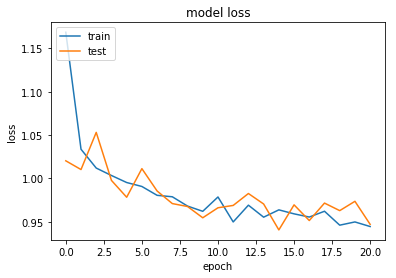

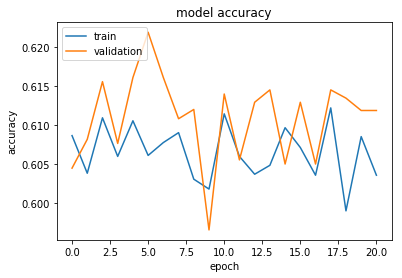

In [100]:
# Plot train and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(model_name + '_loss.png')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(model_name + '_accuracy.png')
plt.show()